# State abstraction beyond exactitude

In the previous notebook, we've illustrated the notion of state equivalence, and shown that we can simplify planning by identifying redundant states. This is quite useful, but also limited: we can't reduce the MDP more than there are fully equivalent states. That might not be enough if we are dealing with a very large state space. In the previous notebook, despite reduction of the state space, we still have 1200 states to deal with, which is not little.

We can use state abstraction to simplify things further than what's feasible through bisimulation. Importantly though, any abstraction beyond removal of fully equivalent states means that the computation of the value and state action value functions will be off. We enter the realm of trade-offs between complexity and accuracy. As the brain's processing capacity is limited, it most likely sacrifices optimal behaviour in favor of computation tractability and is therefore is search for the best solution it can affords the computation of. 

There are two distinct ways in which state abstraction can be achieved (the name we came up with ourselves):
- Heuristic state abstraction
- Metric based state abstraction

The former consists of imposing equivalence between states by "deciding" on which aspects of the problem to focus on for planning. For example, we could imagine that in our specific task, participants decide to ignore the fact that there are two different costs in the task and plan **as if** everything costs the same. Alternatively, participants might plan **as if** energy didn't matter. 

The latter consists of determining based on the transition probability and the reward matrices to determine states similiarity to merge only states that are close together. We will see about this second approach in the next notebook and focus on heuristic state abstraction for noow

## Heuristic state abstraction

To simplify the planning, we can decide on some aspects of the task to ignore. In our task, participants try to maximize the return, which requires them to make sure they have enough energy to accept the reward. As we have seen in the two previous notebooks, to get the maximal possible reward, participants need to take into accout their current energy level, the cost and value of the current offer, but also the cost of future rewards, as well as the trial number. For example, when in the last trial of the first segment, the decision will be different compared to the first trial of a segment for matched energy and reward, because participants know that the costs in the next segment is going to change. For example, if the cost in the next segment is going to increase, when we have low energy and get a medium reward at a low cost in the last trial of the segment, we might decide to accept the reward by fear of not being able to afford a similar reward once the cost increases, whereas we might have rejected it in the first trial of the block. 

But in order to simplify planning, participants might decide to take their decision based solely on their current energy level and the offer being present, discarding any temporal information. Such a heuristic implies that participants consider that all states with the same offer and costs are equivalent regardless of the trial number and future cost. Based on the state equivalence definition that we have laid out in the previous notebook, that means that from the perspective of the agent, the transition probability and reward of all these states are the same, such that the state space becomes:

$$
S = {e\in E, o \in O, c\in C}
$$

We can implement implement the transitional probability and reward associated with such a heuristic. When following such a heuristic, an agent would always assume that the cost is the current cost (i.e. the cost remains the same regardless of the trial number). Furthermore, the transition probability to the next state will be uniformely distributed over offers and trials, i.e. the agent believe it to be equally likely to land on any trial number. We would expect a reduced state space to be $7 (energy) \times 7 (offers) \times 2 (current\ costs) \times 2 (future\ costs) = 196$

In [27]:
import numpy as np
import itertools

E = [0, 1, 2, 3, 4, 5, 6]  # Energy levels
O = [100, 200, 225, 250, 275, 300, 400]  # Offers
C = [1, 2]  # Costs of accepting a reward
T = [1, 2, 3, 4, 5, 6, 7, 8, 9]  # Number of trials in a segment pair 
A = [0, 1]  # Possible actions: 0 = reject, 1=accept
emax = 6  # Max energy level

# Create a list of all possible states:
# Create the entire state space:
states = list(itertools.product(E, O, C, C, T))
state_to_idx = {state: idx for idx, state in enumerate(states)}
idx_to_state = {idx: state for idx, state in enumerate(states)}

# The transition probability matrix maps to each state the probability to land in every other possible state, given the action one has taken
tp_notime = np.zeros([len(states), len(A), len(states)])
r_notime = np.zeros([len(states), len(A)])

# Loop through each possible state:
for a in A:
    for i, state in enumerate(states):
        # Extract the variables from the current state:
        e, o, cc, fc, t = state
        # Interrupt terminal state:
        if t == T[-1]:
            r_notime[state_to_idx[state], a] = e * 2
            continue
        if a == 1 and e >= cc:
            r_notime[state_to_idx[state], a] = o
        
        if a == 0:
            next_states = [state for state in states if (state[0] == min(e+1, 6)) and (state[1] in O) and (state[2] == cc) and (state[3] == fc)]
            for s2 in next_states:
                tp_notime[state_to_idx[state], a, state_to_idx[s2]] = 1/len(next_states)
        else:
            if e > cc:
                next_states = [state for state in states if (state[0] == min(e-cc, 6)) and (state[1] in O) and (state[2] == cc) and (state[3] == fc)]
                for s2 in next_states:
                    tp_notime[state_to_idx[state], a, state_to_idx[s2]] = 1/len(next_states)
            else:
                next_states = [state for state in states if (state[0] == min(0, 6)) and (state[1] in O) and (state[2] == cc) and (state[3] == fc)]
                for s2 in next_states:
                    tp_notime[state_to_idx[state], a, state_to_idx[s2]] = 1/len(next_states)


States in cluster 0: 
[e=0, o=100, cc=1, fc=1, t=1]
[e=0, o=100, cc=1, fc=1, t=2]
[e=0, o=100, cc=1, fc=1, t=3]
[e=0, o=100, cc=1, fc=1, t=4]
[e=0, o=100, cc=1, fc=1, t=5]
[e=0, o=100, cc=1, fc=1, t=6]
[e=0, o=100, cc=1, fc=1, t=7]
[e=0, o=100, cc=1, fc=1, t=8]
[e=0, o=200, cc=1, fc=1, t=1]
[e=0, o=200, cc=1, fc=1, t=2]
[e=0, o=200, cc=1, fc=1, t=3]
[e=0, o=200, cc=1, fc=1, t=4]
[e=0, o=200, cc=1, fc=1, t=5]
[e=0, o=200, cc=1, fc=1, t=6]
[e=0, o=200, cc=1, fc=1, t=7]
[e=0, o=200, cc=1, fc=1, t=8]
[e=0, o=225, cc=1, fc=1, t=1]
[e=0, o=225, cc=1, fc=1, t=2]
[e=0, o=225, cc=1, fc=1, t=3]
[e=0, o=225, cc=1, fc=1, t=4]
[e=0, o=225, cc=1, fc=1, t=5]
[e=0, o=225, cc=1, fc=1, t=6]
[e=0, o=225, cc=1, fc=1, t=7]
[e=0, o=225, cc=1, fc=1, t=8]
[e=0, o=250, cc=1, fc=1, t=1]
[e=0, o=250, cc=1, fc=1, t=2]
[e=0, o=250, cc=1, fc=1, t=3]
[e=0, o=250, cc=1, fc=1, t=4]
[e=0, o=250, cc=1, fc=1, t=5]
[e=0, o=250, cc=1, fc=1, t=6]
[e=0, o=250, cc=1, fc=1, t=7]
[e=0, o=250, cc=1, fc=1, t=8]
[e=0, o=275, cc=1,

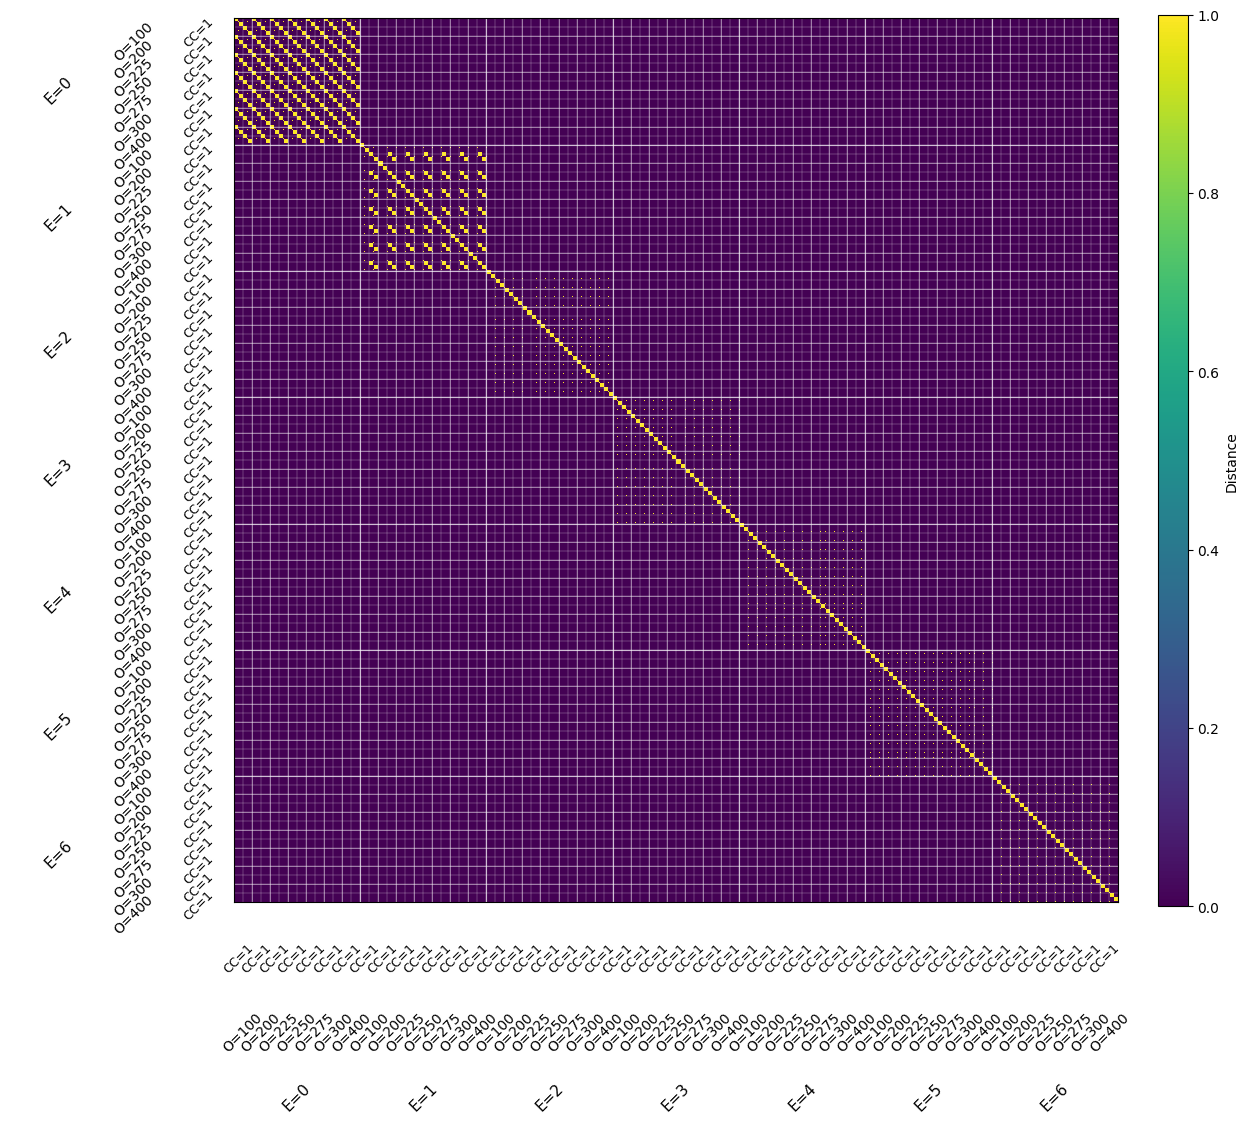

In [28]:
from utils import bisimulation_classes, plot_state_matrix
import matplotlib.pyplot as plt

state_classes, states_equivalence = bisimulation_classes(states, tp_notime, r_notime, verbose=True)
plot_state_matrix(states_equivalence, states, 
                  depth=3, cmap='viridis', 
                  feature_names=["E", "O", "CC", "FC", "T"])
plt.show()

We have 161 classes, which is less than the 196 we had expected. This is not a bug, this is because, on top of the states we have made equivalent by removing the time dimension, we also have the states that were already equivalent (for example with 0 energy, states with different offers are equivalent). Based on this simplification, we can compute the reduced MDP and find the optimal policy for it:

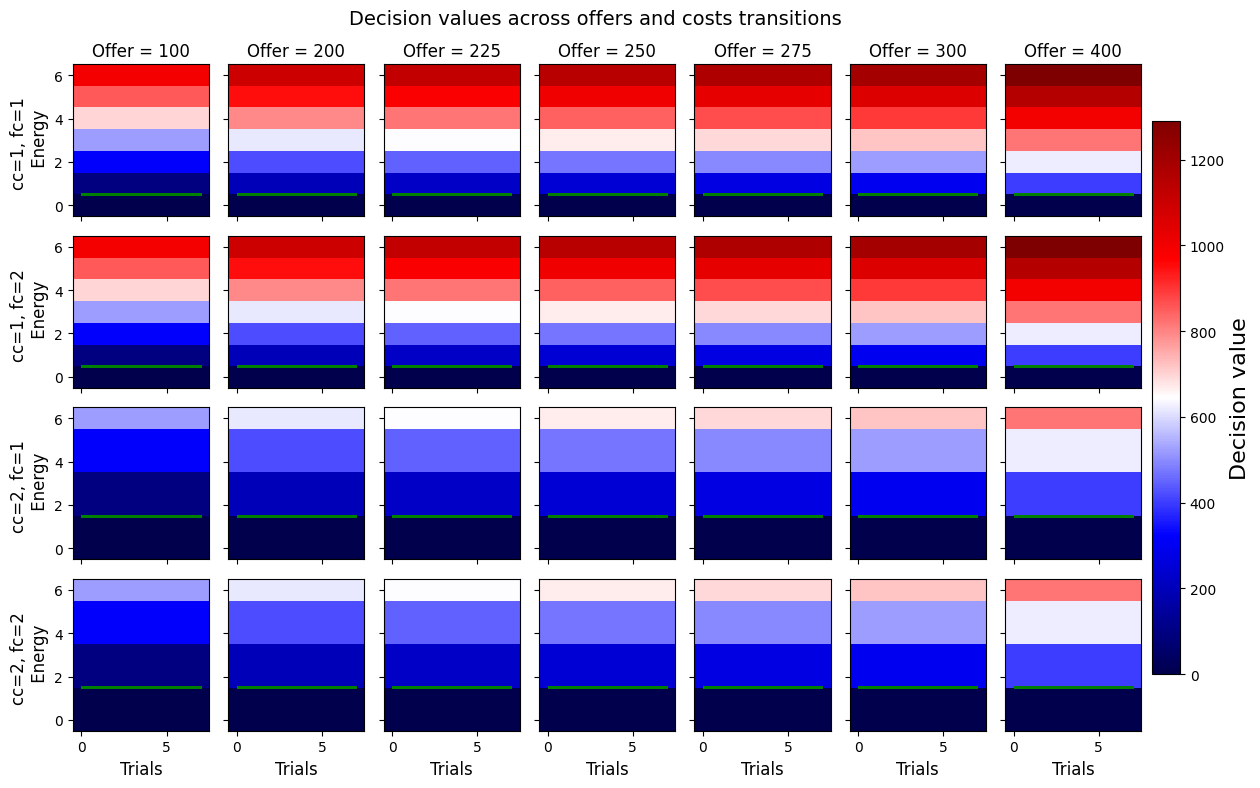

In [29]:
from utils import reduce_mdp, full_state_value, backward_induction, plot_dv, evaluate_policy
# Get the reduced MDP:
tp_reduced, reward_reduced, class_of_state = reduce_mdp([[state_to_idx[state] for state in classe] for classe in state_classes], tp_notime, r_notime)
# Compute value and state action value functions on the reduced MDP:
V, Q = backward_induction([state[0] for state in state_classes], tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value([[state_to_idx[state] for state in classe] for classe in state_classes], V_reduced=V, Q_reduced=Q, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()

Obviously, the trials dimension isn't useful anymore. No matter the trial, the decision value is always the same since it wasn't considered for planning. Interestingly though, the boundary of the decision value (i.e. when to accept vs reject the offer) is now the same across all conditions: always accept if you can afford it. 

Importantly though, we sacrificed quite a lot of information when removing the time dimension from the planning, which implies that the policy we determined to be the best on the reduced MDP will perform much worst than the actual optimal policy obtained by performing backward induction on the full MDP. We can see that by comparing the expected return under the optimal policy and the policy obtained with the reduced MDP:

In [30]:
# The transition probability matrix maps to each state the probability to land in every other possible state, given the action one has taken
tp_true = np.zeros([len(states), len(A), len(states)])
r_true = np.zeros([len(states), len(A)])

# Loop through each possible state:
for a in A:
    for i, state in enumerate(states):
        # Extract the variables from the current state:
        e, o, cc, fc, t = state
        if t == T[-1]:
            r_true[state_to_idx[state], a] = e * 2
            continue
        if t > 4 and a == 1 and e>=fc or t <= 4 and a == 1 and e >= cc:
            r_true[state_to_idx[state], a] = o
        # Get the transition probability to other possible states:
        if t >= 8:
            costs_pairs = [[1, 1], [2, 2], [1, 2], [2, 1]]
            for cp in costs_pairs:
                for o2 in O:
                    if a == 1:
                        if e >= fc:
                            tp_true[state_to_idx[state], a, state_to_idx[e-fc, o2, cp[0], cp[1], t+1]] = 1/(len(O) * len(costs_pairs))
                        else:
                            tp_true[state_to_idx[state], a, state_to_idx[0, o2, cp[0], cp[1], t+1]] = 1/(len(O) * len(C))
                    else:
                        tp_true[state_to_idx[state], a, state_to_idx[min(emax, e+1), o2, cp[0], cp[1], t+1]] = 1/(len(O) * len(C))
        elif 4 < t < 8:
            if a == 1:
                if e >= fc:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[e-fc, o2, cc, fc, t+1]] = 1/len(O)
                else:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[0, o2, cc, fc, t+1]] = 1/len(O)
            else:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[min(emax, e+1), o2, cc, fc, t+1]] = 1/len(O)
        else:  
            if a == 1:
                if e >= cc:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[e-cc, o2, cc, fc, t+1]] = 1/len(O)
                else:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[0, o2, cc, fc, t+1]] = 1/len(O)
            else:
                    for o2 in O:
                        tp_true[state_to_idx[state], a, state_to_idx[min(emax, e+1), o2, cc, fc, t+1]] = 1/len(O)

V_opt, Q_opt = backward_induction(states, tp_true, r_true, tdim=4)

# Get the optimal and reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
optimal_policy = np.array(Q_opt[:, 1] - Q_opt[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
value_optimal_policy, _ = evaluate_policy(states, tp_true, r_true, optimal_policy, tdim=4)

start_idx = [i for i,s in enumerate(states) if s[4]==1 and s[0]==3]
mu0 = np.zeros(len(states))
mu0[start_idx] = 1.0 / len(start_idx)

print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

Expected total return under reduced policy: 941.9999999999998
Expected total return under optimal policy: 1218.594894862806


## Lumping states
In the previous example, we manually figured out the modification required to the transition probability and reward script to make the time dimension redundant. That's a bit tedious. Instead, we can make use of the ``reduce_mdp`` function we had in the previous chapter. That function can indeed take a set of classes and returns the reduced MDP by averaging their TP and reward together. We can therefore pass it custom made classes of states to yield the reduced MDP. For example, let's say we want to lump all pairs of time points together [1, 2], [3, 4], [5, 6], [7, 8], we can manually create these classes to obtain the reduced MDP:

In [31]:
states_classes = []
# Loop through time in increments of 2: 1, 3, 5, 7
for t in range(T[0], T[-1], 2):
    # List through all other state variables:
    for e, o, cc, fc in list(itertools.product(E, O, C, C)):
        # Append states of the pair of time points:
        states_classes.append([(e, o, cc, fc, t), (e, o, cc, fc, t+1)])
# Append the terminal state:
for e, o, cc, fc in list(itertools.product(E, O, C, C)):
    states_classes.append([(e, o, cc, fc, 9)])
# Get the indices of states in each class:
classes_indices = [[state_to_idx[state] for state in class_] for class_ in states_classes]
# Reduce the MDP:
tp_reduced, reward_reduced, class_of_state = reduce_mdp(classes_indices, tp_true, r_true)

Now that we have the reduced MDP associated with lumping every pairs of time points together, we can compute the optimal value and state action value functions with backward inductions and evaluate the policy:

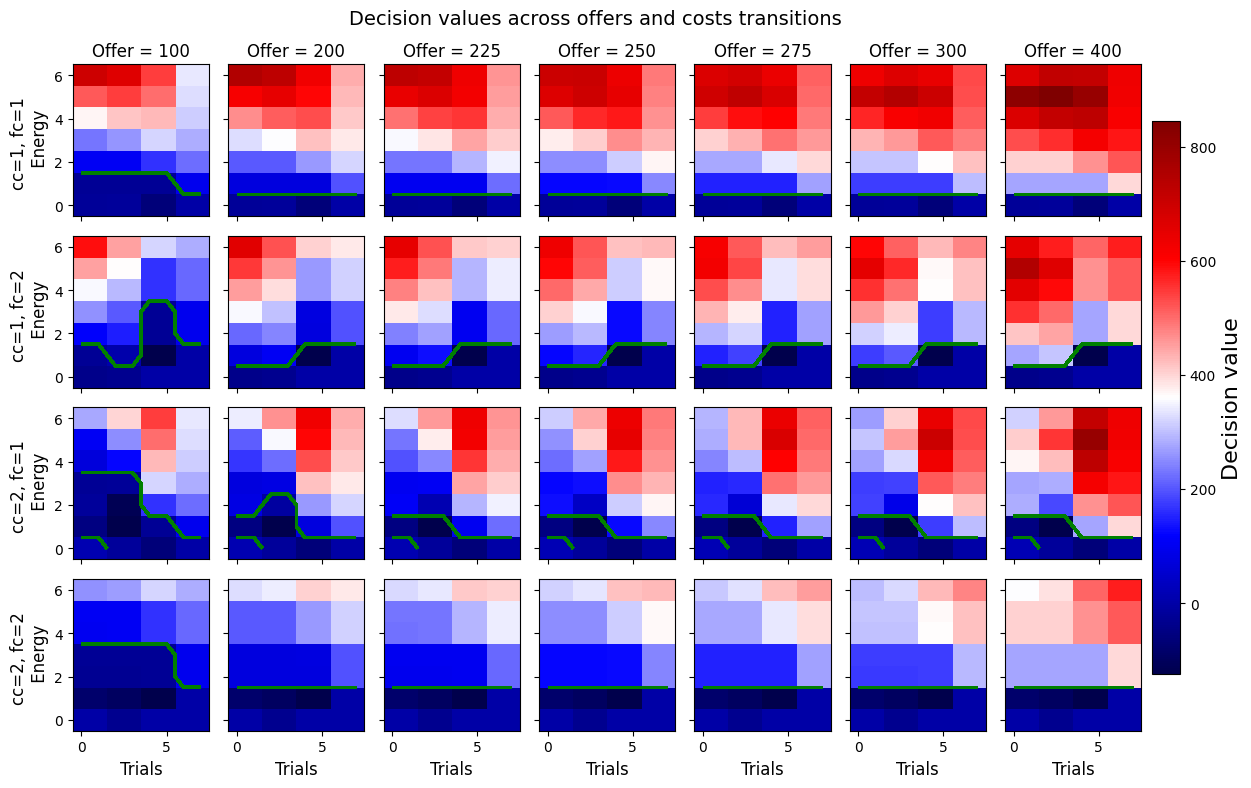

In [32]:
# Backward induction on the reduced MDP:
V_reduced, Q_reduced = backward_induction([tuple(states[0]) for states in states_classes], tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value(classes_indices, V_reduced=V_reduced, Q_reduced=Q_reduced, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()

And once again, we can compute the reduced policy, to see how good it performs compared to the optimal policy:

In [33]:
# Compute the reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

Expected total return under reduced policy: 1060.5874635568512
Expected total return under optimal policy: 1218.594894862806


We can see that such a reduced policy still underperforms compare to the full policy, but it is doing better than the policy in which we removed time altogether, which intuitively makes sense: lumping pairs of time points is less coarse than lumping all time points together. Now let's try to lump offers in a similar fashion to see what happens:

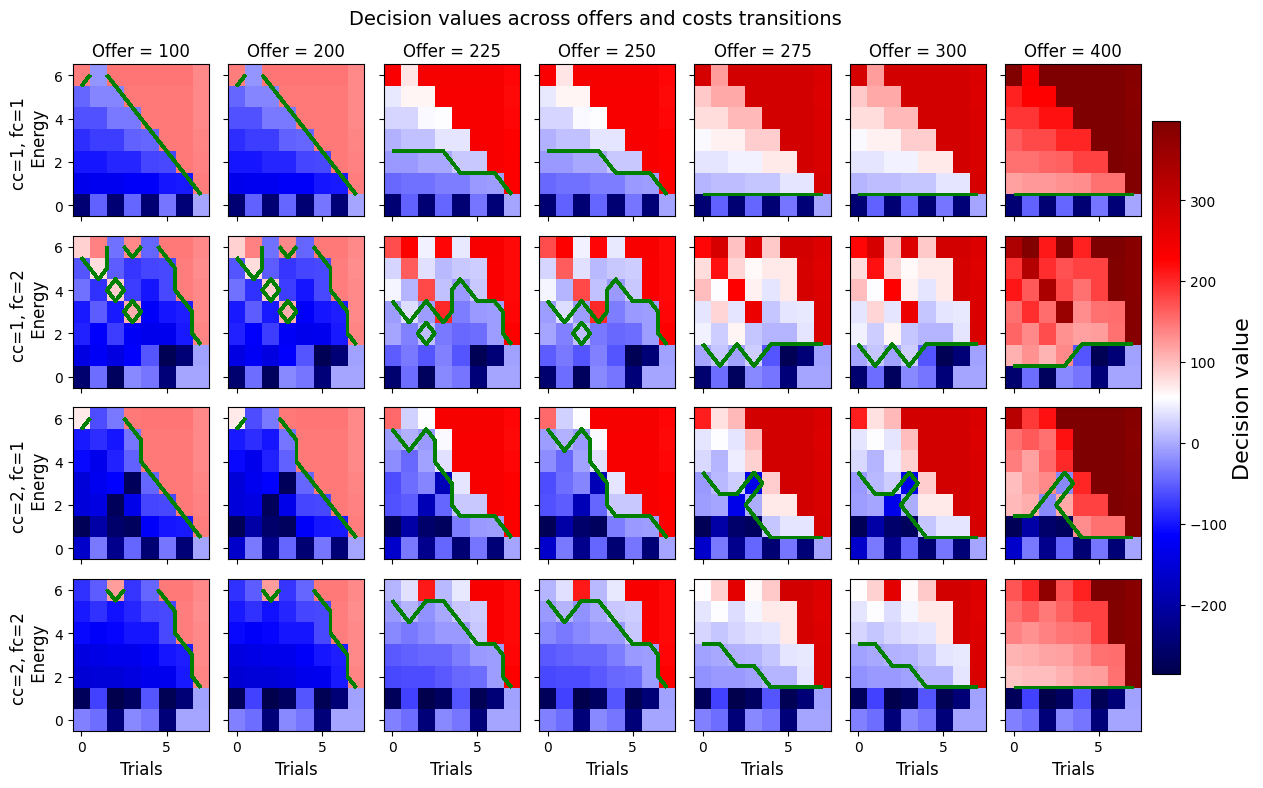

Expected total return under reduced policy: 1216.386467980421
Expected total return under optimal policy: 1218.594894862806


In [34]:
states_classes = []
# Loop through offers in increments of 2: 0, 2, 4, 6
for o_i in range(0, len(O), 2):
    for e, cc, fc, t in list(itertools.product(E, C, C, T)):
        if o_i+1 > len(O) - 1:
            states_classes.append([(e, O[o_i], cc, fc, t)])
        else:
            states_classes.append([(e, O[o_i], cc, fc, t), (e, O[o_i+1], cc, fc, t)])
classes_indices = [[state_to_idx[state]  # Get the indices of states in each class:
                    for state in class_] 
                    for class_ in states_classes]
tp_reduced, reward_reduced, class_of_state = reduce_mdp(  # Reduce the MDP:
    classes_indices, tp_true, r_true)  

V_reduced, Q_reduced = backward_induction([tuple(states[0])  # Backward induction on the reduced MDP:
                                           for states in states_classes], 
                                           tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value(classes_indices, V_reduced=V_reduced, Q_reduced=Q_reduced, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()
# Compute the reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

Such a policy is particularly promising, because we can see, we get really close to the optimal policy results. That also intuitively kind of makes sense, though I'm a bit surprised by how well it does compared to the lumping of time points. We can see what would happen if we were to lump rewards even more, for example split into high and low reward:

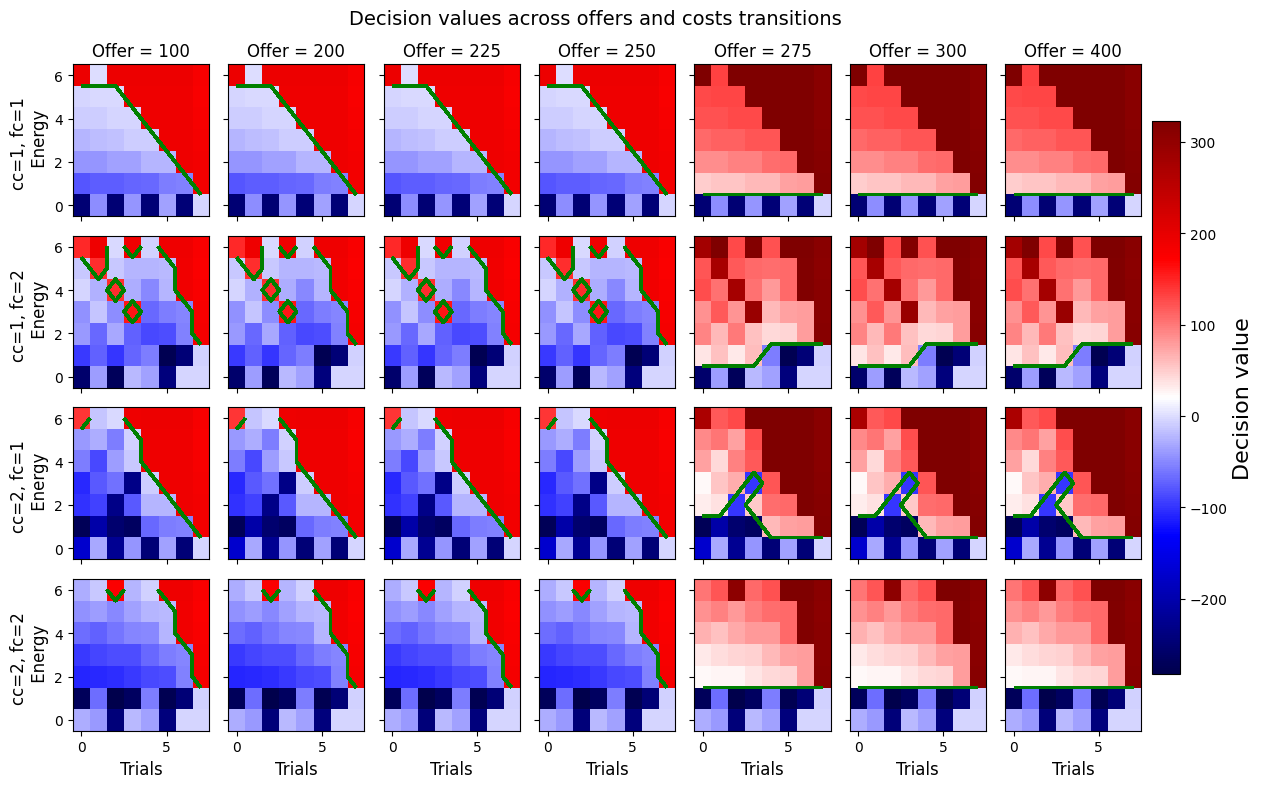

Expected total return under reduced policy: 1204.7705508394822
Expected total return under optimal policy: 1218.594894862806


In [35]:
states_classes = []
# Loop through offers in increments of 2: 0, 2, 4, 6
for os in [[O[0], O[1], O[2], O[3]], [O[4], O[5], O[6]]]:
    for e, cc, fc, t in list(itertools.product(E, C, C, T)):
        states_classes.append([(e, o, cc, fc, t) for o in os])
classes_indices = [[state_to_idx[state]  # Get the indices of states in each class:
                    for state in class_] 
                    for class_ in states_classes]
tp_reduced, reward_reduced, class_of_state = reduce_mdp(  # Reduce the MDP:
    classes_indices, tp_true, r_true)  

V_reduced, Q_reduced = backward_induction([tuple(states[0])  # Backward induction on the reduced MDP:
                                           for states in states_classes], 
                                           tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value(classes_indices, V_reduced=V_reduced, Q_reduced=Q_reduced, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()
# Compute the reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

Also not too bad. Now let's try to lump energy levels together in a similar fashion:

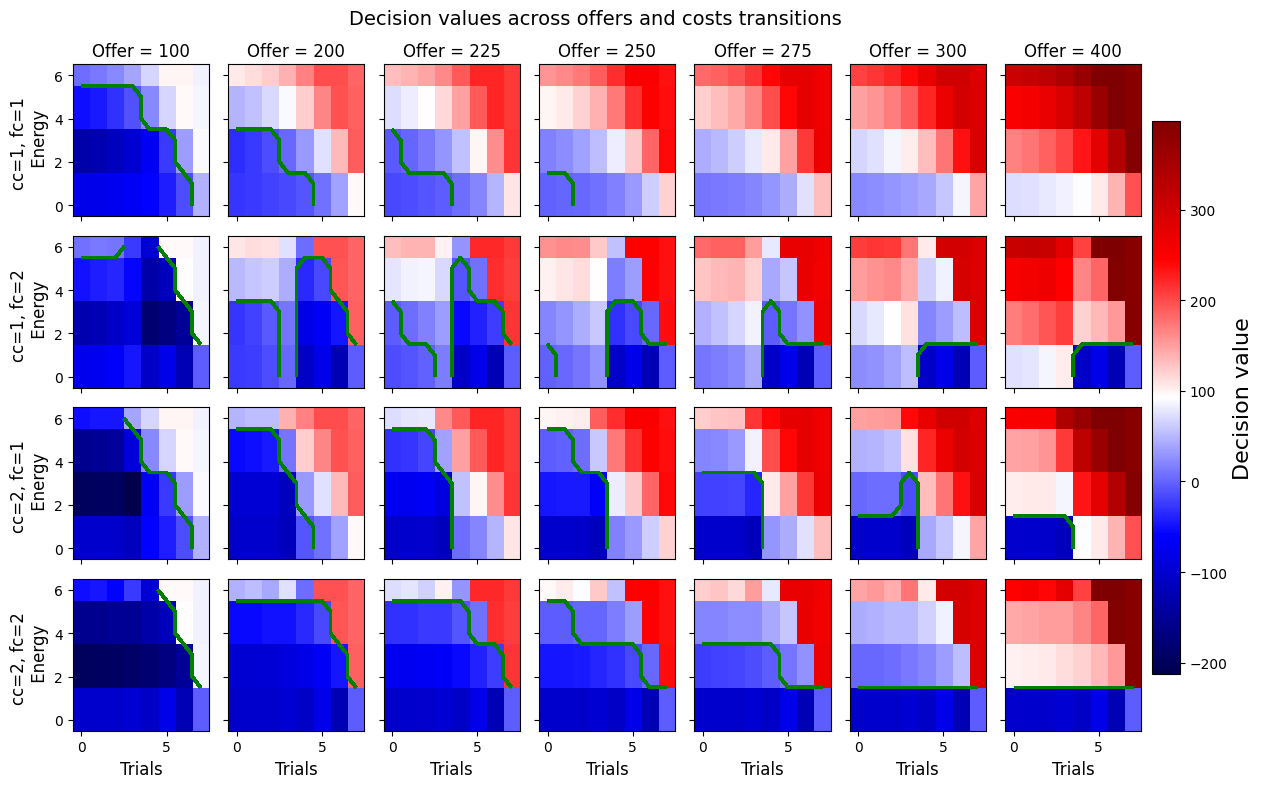

Expected total return under reduced policy: 1152.2363282791546
Expected total return under optimal policy: 1218.594894862806


In [36]:
states_classes = []
# Loop through offers in increments of 2: 0, 2, 4, 6
for e_i in range(0, len(E), 2):
    for o, cc, fc, t in list(itertools.product(O, C, C, T)):
        if e_i+1 > len(O) - 1:
            states_classes.append([(E[e_i], o, cc, fc, t)])
        else:
            states_classes.append([(E[e_i], o, cc, fc, t), (E[e_i+1], o, cc, fc, t)])
classes_indices = [[state_to_idx[state]  # Get the indices of states in each class:
                    for state in class_] 
                    for class_ in states_classes]
tp_reduced, reward_reduced, class_of_state = reduce_mdp(  # Reduce the MDP:
    classes_indices, tp_true, r_true)  

V_reduced, Q_reduced = backward_induction([tuple(states[0])  # Backward induction on the reduced MDP:
                                           for states in states_classes], 
                                           tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value(classes_indices, V_reduced=V_reduced, Q_reduced=Q_reduced, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()
# Compute the reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

And finally for the costs:

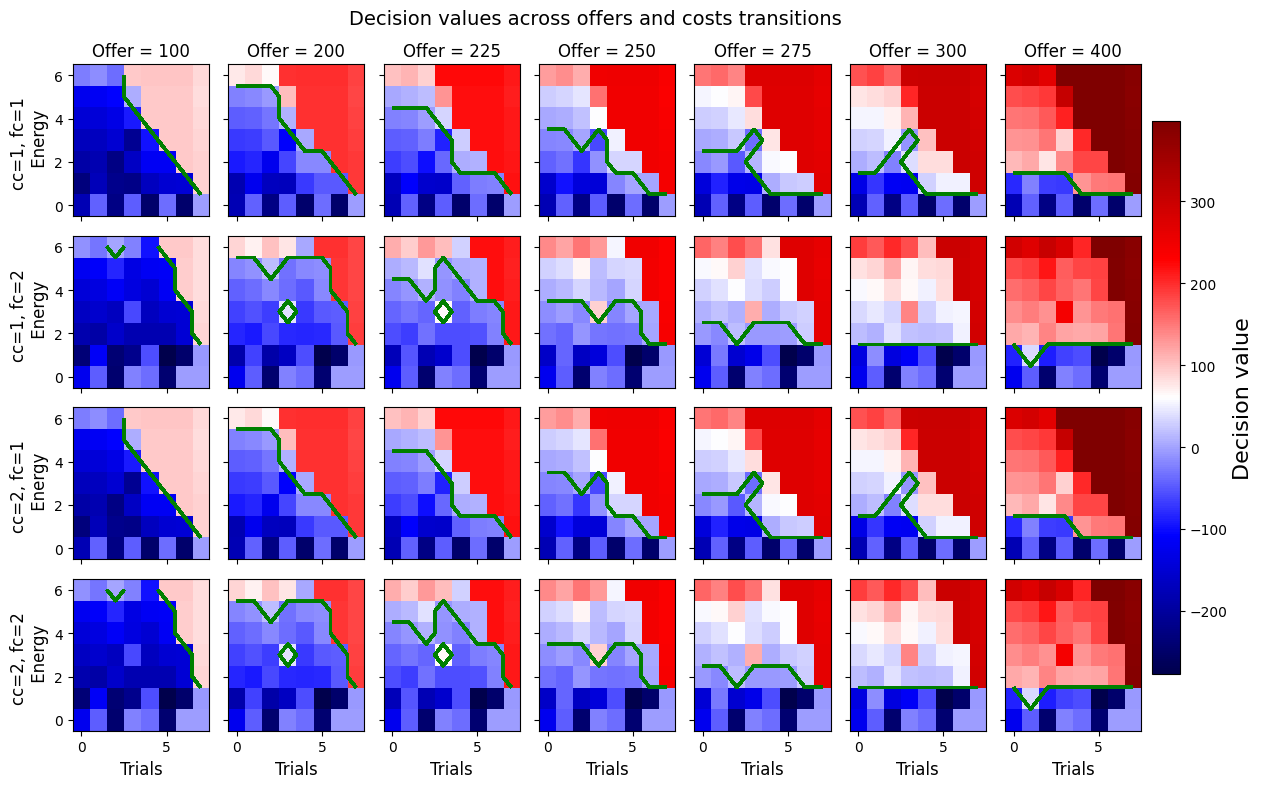

Expected total return under reduced policy: 1204.71979149844
Expected total return under optimal policy: 1218.594894862806


In [37]:
states_classes = []
# Loop through offers in increments of 2: 0, 2, 4, 6
for e, o, fc, t in list(itertools.product(E, O, C, T)):
    states_classes.append([(e, o, C[0], fc, t), (e, o, C[1], fc, t)])
classes_indices = [[state_to_idx[state]  # Get the indices of states in each class:
                    for state in class_] 
                    for class_ in states_classes]
tp_reduced, reward_reduced, class_of_state = reduce_mdp(  # Reduce the MDP:
    classes_indices, tp_true, r_true)  

V_reduced, Q_reduced = backward_induction([tuple(states[0])  # Backward induction on the reduced MDP:
                                           for states in states_classes], 
                                           tp_reduced, reward_reduced, tdim=4)
# Project back to full state space:
V_from_reduced, Q_from_reduced, class_of_state = full_state_value(classes_indices, V_reduced=V_reduced, Q_reduced=Q_reduced, S=None)
# Plot the decision values:
plot_dv(Q_from_reduced[:, 1] - Q_from_reduced[:, 0], C, O, E, T, state_to_idx)
plt.show()
# Compute the reduced policy:
reduced_policy = np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int)
value_reduced_policy, _ = evaluate_policy(states, tp_true, r_true, reduced_policy, tdim=4)
print("Expected total return under reduced policy:", mu0 @ value_reduced_policy)
print("Expected total return under optimal policy:", mu0 @ value_optimal_policy)

Also surprisingly, not bad at all. Removing the trial dimension is surprisingly what has the worst effect on the accuracy. 

Anyhow, so far we have been trying everything in a very manual fashion. But there are many other ways of doing lumping. Different lumping reduce the MDP to different extent. Accordingly, the loss in accuracy should also be weigthed by the reduction in dimensions of the problem, because what we ultimately we are dealing with an accuracy complexity trade off. We will now design an algorithm to compute all possible lumping options in our state space (limiting ourselves to lumping only one state at a time and not testing combination of lumpings for now). To that end, we will create a class called heuristic state abstraction that computes the decision values associated with each possible lumping and return the return of that policy, weigthed by the complexity of the reduced MDP

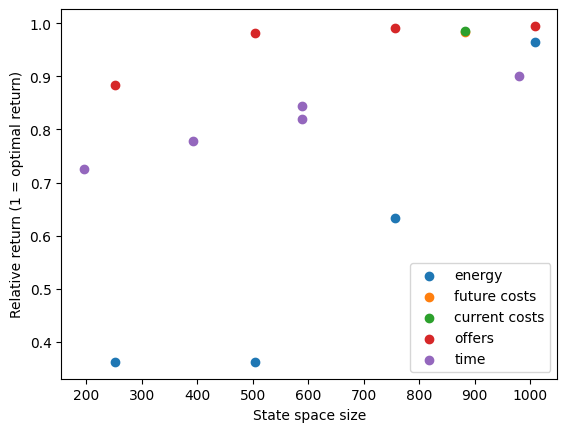

In [44]:
from dataclasses import dataclass, field
import itertools
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rng
import pandas as pd

from utils import backward_induction


@dataclass
class TaskConfig:
    """
    Configuration object for the sequential decision-making task.

    Attributes
    ----------
    n_trials_per_segment : int
        Number of trials per cost segment.
    tmax : int
        Maximum number of trials (time horizon).
    initial_energy : int
        Initial energy level at the start of the task.
    max_energy : int
        Maximum possible energy level.
    min_energy : int
        Minimum possible energy level.
    costs : list[int]
        Possible cost levels for actions.
    energy : list[int]
        Discrete energy states.
    offers : list[int]
        Possible reward offers available at each trial.
    p_offer : list[float]
        Probability distribution over offers.
    actions : list[int]
        Possible actions (typically 0 = reject, 1 = accept).
    """
    # Structure of the task:
    n_trials_per_segment: int = 4
    tmax: int = 9
    
    # Energy
    initial_energy: int = 3
    max_energy: int = 6
    min_energy = 0
    energy_bonus = 0.5

    # Costs
    C: list[int] = field(default_factory=lambda: [1, 2])

    # Rewards:
    E: list[int] = field(default_factory=lambda: [0, 1, 2, 3, 4, 5, 6])
    O: list[int] = field(default_factory=lambda: [100, 200, 225, 250, 275, 300, 400])
    p_offer: list[int] = field(default_factory=lambda: [1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7])

    # Actions:
    A: list[int] = field(default_factory=lambda: [0, 1])


class HeuristicStateAbstraction:
    """
    Performs dynamic programming (value iteration or backward induction)
    for computing state-action values in a finite-horizon decision problem.
    """
    def __init__(self, config: TaskConfig):
        """
        Initialize the dynamic programming solver.

        Parameters
        ----------
        config : TaskConfig
            Configuration object specifying the task structure and parameters.
        """
        # Set task config:
        self.config = config

        # Get dimensions:
        self.n_energy  = len(self.config.E)  # Number of energy states
        self.n_offers  = len(self.config.O)  # Number of offers
        self.n_cc      = len(self.config.C)   # Number of current costs
        self.n_fc      = len(self.config.C)   # Number of future costs
        self.T         = list(range(1, self.config.tmax + 1, 1))
        self.n_steps   = self.config.tmax         # Number of steps
        self.n_actions = len(self.config.A) # Number of actions 
        self.states    = list(itertools.product(self.config.E, self.config.O, self.config.C, self.config.C, self.T))  # All possible states in state space
        self.state_to_idx = {state: idx for idx, state in enumerate(self.states)}  # Index of each state
        self.idx_to_state = {idx: state for idx, state in enumerate(self.states)}  # State of each index
        self.nstates   = len(self.states)  # Number of states
        self.tdim      = 4  # Index of the time dimension
        self.energy_dim = 0  # Index of the energy dimension
        self.dimension_names = ['energy', 'offers', 'current costs', 'future costs', 'time']

        # Compute the transition probability and rewards:
        self.transition_probability()
        self.reward()

        # Compute the optimal value and state action value functions:
        self.V_opt, self.Q_opt = backward_induction(self.states,
                                                    self.tp,
                                                    self.r,
                                                    tdim=self.tdim)
        # Compute the optimal policy:
        self.policy_opt = np.array(self.Q_opt[:, 1] - self.Q_opt[:, 0] > 0).astype(int)
                                                
    
    def transition_probability(self):
        """
        Compute the transition_probability matrix of the full MDP, mapping the probability
        to land in any possible future state given the current state and action, formally:
        P(s'|s, a) = S x A x X

        Returns
        -------
        tuple[list[list[int]], list[float]]
            A tuple of (next_states, transition_probabilities).
        """
        # The transition probability matrix maps to each state the probability to land in every other possible state, given the action one has taken
        self.tp = np.zeros([self.nstates, self.n_actions, self.nstates])

        # Loop through each possible state:
        for a in self.config.A:
            for state in self.states:
                # Extract the variables from the current state:
                e, o, cc, fc, t = state
                # Skip if terminal state:
                if t == self.T[-1]:
                    continue
                
                # Determine the next states variables values:
                # Current and future cost stay fixed, next t is always t+1:
                cc2 = cc  
                fc2 = fc
                t2 = t+1

                # The next energy is a function of action, current energy level and costs (which depends on t)
                if t <= 4:  # Within the first segment, the cost cc applies
                    cost = cc
                else:
                    cost = fc

                # If enough energy to accept reward and accept reward, loose energy
                if a == 1 and e >= cost: 
                    e2 = e-cost
                elif a == 1 and e < cost:  # If not enough energy but accept nonetheless, set energy to 0
                    e2 = 0
                else:  # If participants reject, increase energy by 1 up to max energy
                    e2 = min(e+1, self.config.max_energy)

                # Finally, offer in the next trials are stochastic:
                # Handling the specific case of trials beyond the horizon:
                if t >= self.config.n_trials_per_segment * 2:
                    # If we are beyond the segment pairs, cc and fc are unknown and are 
                    # equally likely to take any values
                    for cc2, fc2 in list(itertools.product(self.config.C, self.config.C)):
                        for o2 in self.config.O:
                            # The probability is the probability of each offer times 
                            # the probability of each possible costs:
                            self.tp[self.state_to_idx[state], a, 
                                    self.state_to_idx[(e2, o2, cc2, fc2, t2)]] = self.config.p_offer[self.config.O.index(o2)] * 1/self.n_cc**2
                else:
                    # The next trial can have any of the possible offers depending on their probability:
                    for o2 in self.config.O:
                        self.tp[self.state_to_idx[state], a, 
                                self.state_to_idx[(e2, o2, cc2, fc2, t2)]] = self.config.p_offer[self.config.O.index(o2)]
                        
        return self.tp
    
    def reward(self):
        """
        Compute the immediate reward, mapping the immediate reward associated with each state:
        P(s'|s, a) = S x A x X

        Returns
        -------
        tuple[list[list[int]], list[float]]
            A tuple of (next_states, transition_probabilities).
        """
        self.r = np.zeros([self.nstates, len(A)])
        
        # Loop through each possible state:
        for a in self.config.A:
            for state in self.states:
                # Extract the variables from the current state:
                e, o, cc, fc, t = state
                # In the terminal state, the immediate reward is a function of the energy:
                if t == self.T[-1]:
                    self.r[self.state_to_idx[state], a] = e * self.config.energy_bonus
                # Reward is equal to the offer if the agent accepts and can afford it
                if a == 1:
                    if t > self.config.n_trials_per_segment and e>=fc or t <= self.config.n_trials_per_segment and e >= cc:
                        self.r[self.state_to_idx[state], a] = o

    def evaluate_policy(self, policy):
        """
        Compute expected return under a given policy for a finite-horizon MDP.
        - policy: 
            if deterministic -> shape (S,) with integer actions
            if stochastic -> shape (S,A) with probs summing to 1
        Returns
        -------
        V : (S,) value function under the specified policy
        Q : (S,A) state action value function under the specified policy
        """
        V = np.zeros(self.nstates)
        Q = np.zeros((self.nstates, self.n_actions))
        T = sorted({s[self.tdim] for s in states})

        # backward sweep
        for t in reversed(T):
            idx_t = [i for i, s in enumerate(states) if s[self.tdim] == t]
            for i in idx_t:
                for a in self.config.A:
                    Q[i,a] = self.r[i,a] + self.tp[i,a,:] @ V
                # deterministic policy
                if policy.ndim == 1:
                    V[i] = Q[i, policy[i]]
                else:
                    V[i] = (policy[i] * Q[i]).sum()
        return V, Q
    
    def compute_return(self, policy):
        """
        Compute expected return under a given policy for a finite-horizon MDP.
        Returns
        -------
        U : (float) expected return of a policy
        """
        # Compute the value of the policy:
        V, _ = self.evaluate_policy(policy)

        # Compute expected return of the policy
        start_idx = [i for i,s in enumerate(self.states) if s[self.tdim]==1 and s[self.energy_dim]==self.config.initial_energy]
        mu0 = np.zeros(len(self.states))
        mu0[start_idx] = 1.0 / len(start_idx)
        return mu0 @ V
    
    
    def reduce_mdp(self, classes):
        """
        Collapse an MDP given exact bisimulation classes.
        classes: list[list[int]] where each inner list contains original state indices.
        tp: (S, A, S) transition probs
        reward: (S, A) rewards
        Returns: (tp_reduced (K, A, K), reward_reduced (K, A), class_of_state (S,))
        """
        K = len(classes)

        # Map each original state -> its class
        class_of_state = np.empty(self.nstates, dtype=int)
        for k, idxs in enumerate(classes):
            class_of_state[idxs] = k

        # One-hot class indicator matrix M: (S, K), used to sum probs into classes
        M = np.zeros((self.nstates, K), dtype=float)
        for k, idxs in enumerate(classes):
            M[idxs, k] = 1.0

        # Average rewards within each class
        reward_reduced = np.empty((K, self.n_actions), dtype=float)
        for k, idxs in enumerate(classes):
            reward_reduced[k, :] = self.r[idxs, :].mean(axis=0)

        # Average transitions within each class, then pool to classes
        tp_reduced = np.empty((K, self.n_actions, K), dtype=float)
        for k, idxs in enumerate(classes):
            for a in range(self.n_actions):
                # mean over members of class k → distribution over original S
                avg_row = self.tp[idxs, a, :].mean(axis=0)          # (S,)
                # pool S → K
                tp_reduced[k, a, :] = avg_row @ M              # (K,)

        return tp_reduced, reward_reduced, class_of_state
    
    def full_state_value(self, classes, V_reduced=None, Q_reduced=None, S=None):
        """

        classes: list[list[int]] partition of states.
        V_reduced: (K,), Q_reduced: (K, A). Either may be None.
        S: optional total #states. If None, inferred from classes.
        Returns: (V_full (S,), Q_full (S, A), class_of_state (S,))
        """
        if S is None:
            S = max(i for cls in classes for i in cls) + 1

        class_of_state = np.full(S, -1, dtype=int)
        for k, idxs in enumerate(classes):
            class_of_state[np.asarray(idxs, dtype=int)] = k

        if (class_of_state == -1).any():
            missing = np.flatnonzero(class_of_state == -1)[:10]
            raise ValueError(f"Some states not in any class, e.g. {missing}…")

        V_full = None if V_reduced is None else np.asarray(V_reduced)[class_of_state]
        Q_full = None if Q_reduced is None else np.asarray(Q_reduced)[class_of_state, :]

        return V_full, Q_full, class_of_state
    
    
    def evaluate_abstraction(self, states_classes):
        """
        Evaluate abstraction  by computing 
        tp: (S, A, S) transition probs
        reward: (S, A) rewards
        Returns: (tp_reduced (K, A, K), reward_reduced (K, A), class_of_state (S,))
        """
        # Retrive the index of each state class:
        class_indices = [[self.state_to_idx[tuple(state)] for state in class_] for class_ in states_classes]
        # Compute the reduced mpd:
        tp_reduced, reward_reduced, class_of_state = self.reduce_mdp(class_indices)
        # Backward induction on the reduced MDP:
        V_reduced, Q_reduced = backward_induction([states[0] for states in states_classes],
                                                  tp_reduced, reward_reduced, 
                                                  tdim=self.tdim)
        # Project back to the full state space:
        _, Q_from_reduced, _ = self.full_state_value(class_indices, 
                                                     V_reduced=V_reduced, 
                                                     Q_reduced=Q_reduced, S=None)
        # Compute the return:
        return self.compute_return(np.array(Q_from_reduced[:, 1] - Q_from_reduced[:, 0] > 0).astype(int))
    
    def lumping(self, vals):
        """
        This function creates all possible lumpings based on the number of values in the variable. 
        Importantly, beyond a half split, only consider a lumping of all values together.
        [1,2,3,4,5,6,7] →
            [[ [1,2], [3,4], [5,6], [7] ],
            [ [1,2,3], [4,5,6], [7] ],
            [ [1,2,3,4], [5,6,7] ],
            [ [1,2,3,4,5,6,7] ]]
        """
        n = len(vals)
        result = []
        for block in range(2, n + 1):
            if block > n // 2 + 1:  # beyond halfway, only take the full set
                if not result or result[-1] != [vals]:
                    result.append([vals])
                break
            groups = [vals[i:i+block] for i in range(0, n, block)]
            result.append(groups)
        return result
    
    def lump_variables(self, dim, groups):
        """
        This function lumps togther states along a particular dimension. 
        """
        classes = []
        # Loop through each state:
        for state in self.states:
            # Loop through each group
            for g in groups:
                if state[dim] == g[0]:
                    classes.append([tuple(list(state[:dim]) + [v] + list(state[dim+1:])) for v in g]) 
                    break

        return classes

    def compute_abstractions(self):
        """
        This function computes all possible abstraction levels for each variables
        """
        abstraction_variable = []
        abstraction_size = []
        abstraction_level = []
        abstraction_score = []

        # Loop through each variables in the state space:
        for var_i, var in enumerate([self.config.E, self.config.O, self.config.C, self.config.C, self.T]):
            # Loop over all possible lumpings of this variable:
            for lumps in self.lumping(var):
                # Compute the classes:
                states_classes = self.lump_variables(var_i, lumps)
                # Calculate the size of the abstraction:
                abstraction_size.append(len(states_classes))
                abstraction_variable.append(self.dimension_names[var_i])
                # Compute abstraction score:
                abstraction_score.append(self.evaluate_abstraction(states_classes) / self.compute_return(self.policy_opt))
                # Add the abstraction level:
                abstraction_level.append(len(lumps[0]))
        return np.array(abstraction_variable), np.array(abstraction_size), np.array(abstraction_score), np.array(abstraction_level)
    

# Initialize the task:
config = TaskConfig(tmax=9)
# Compute the optimal value and state-action functions:
abstractor = HeuristicStateAbstraction(config)

# Compute the score for all abstractions:
abstraction_variable, abstraction_size, abstraction_score, abstraction_level = abstractor.compute_abstractions()

# Plot the results:
fig, ax = plt.subplots()
for var_i, var in enumerate(list(set(abstraction_variable))):
    ax.scatter(abstraction_size[abstraction_variable == var], abstraction_score[abstraction_variable == var], label=f'{var}')
ax.legend()
ax.set_ylabel('Relative return (1 = optimal return)')
ax.set_xlabel('State space size')
plt.show()


This graph represents the relative return (return / optimal return) of each abstracted MDP as a function of the size of the resulting state space. The colour represent the feature that was lumped, and each dot of a given color represent a certain level of abstraction of that feature (for energy, we lumped every pairs of energy levels, every triplets...). We can clearly see that the decrease in return depends strongly on the feature being affected. For example, if we lump energy, we see a clear exponential decrease in return, such that return aren't too bad if we lump pairs of energy levels ([0, 1], [2, 3]...) but plummets when we go beyond (triplets or quadruplets). In comparison, merging the offers doesn't really lead to that large of a decrease: if we merge every neighboring pairs, or even triplets, we still have very good return, only if don't differentiate between offers at all do we see a dip. 

# Bibliography
<a name="bib_ref-1"></a>[<sup>[1]</sup>](#bib_ref-1) Li, L., Walsh, T. J., & Littman, M. L. (2006). Towards a unified theory of state abstraction for MDPs. AI&M, 1(2), 3.
<a name="bib_ref-2"></a>[<sup>[2]</sup>](#bib_ref-2) Givan, R., Dean, T., & Greig, M. (2003). Equivalence notions and model minimization in Markov decision processes. Artificial intelligence, 147(1-2), 163-223.
<a name="bib_ref-3"></a>[<sup>[1]</sup>](#bib_ref-3) Dean, T., & Givan, R. (1997, July). Model minimization in Markov decision processes. In AAAI/IAAI (pp. 106-111).